In [1]:
import netket as nk
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry import FermionicOperator
import numpy as np
import sys
import json
sys.path.insert(0, '/Users/yapple/Documents/ugent/Ma2/SCQS/FermionicANN/code')
from JW_hamiltonian import JW_H
import torch
import matplotlib.pyplot as plt
import itertools
from system_dicts import *
from collections import Counter

/Users/yapple/.pyenv/versions/miniconda3-4.7.12/envs/nkcenv/lib/python3.7/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [ ]:


#systemData = b631g_H2[4]
systemData = sto3g_H2_eq
systemData = sto3g_LiH_eq

#systemData={'driver_string': 'H 0.0 0.0 0.0; H 0.0 0.0 0.734', 'basis': 'sto3g'}; n_electrons=2
#systemData={'driver_string': 'H 0.0 0.0 0.0; H 0.0 0.0 0.734', 'basis': '631g'}; n_electrons=2
#systemData={'driver_string': 'Li 0.0 0.0 0.0; H 0.0 0.0 1.54', 'basis': 'sto3g'}; n_electrons=4
#systemData={'driver_string': 'C 0.0 0.0 0.0; C 0.0 0.0 1.26', 'basis': 'sto3g'}; n_electrons=12

print(systemData)
driver = PySCFDriver(   atom=systemData["atomstring"],
                        basis=systemData["basis"])
                        
mol = driver.run()
OB = mol.one_body_integrals
TB = mol.two_body_integrals

nre = mol.nuclear_repulsion_energy

FerOp = FermionicOperator(OB, TB)
#FerOp.fermion_mode_elimination([0])
mapping = FerOp.mapping('jordan_wigner')
weights = [w[0] for w in mapping.paulis]
operators = [w[1].to_label() for w in mapping.paulis]
ha = nk.operator.PauliStrings(operators, weights)

g = nk.graph.Hypercube(n_dim=1, length=ha.hilbert.size, pbc=False)
hi = nk.hilbert.Qubit(graph=g)
assert(hi.size==ha.hilbert.size)


In [ ]:
res = nk.exact.lanczos_ed(ha, first_n=1, compute_eigenvectors=True)
print("Exact ground state energy = {}".format(res.eigenvalues[0] + nre))

In [ ]:
[i for i in res.eigenvectors[0] if np.abs(i)>1e-3]

In [ ]:
ha.get_conn([1,0,1,0])

In [ ]:
print(ha.to_sparse())

In [35]:
# Define system params
# Hard coded for C2
systemData = sto3g_H2_eq
# systemData = sto3g_C2_eq
# systemData = sto3g_LiH_eq

n_electrons = systemData['n_electrons']

# make hamiltonian operator
ha = JW_H(systemData=systemData)

g = nk.graph.Hypercube(n_dim=1, length=ha.hilbert.size, pbc=False)
hi = nk.hilbert.Qubit(graph=g)

# Do exact diagonalisation to extract the ground state wf
exact_result = nk.exact.lanczos_ed(ha, first_n=1, compute_eigenvectors=True)

print('exact energy:', exact_result.eigenvalues[-1]) 
ED_wf = exact_result.eigenvectors[-1]
print('len:',len(ED_wf))

# Calculate square moduli
amplitudes_ED = np.abs(np.array(ED_wf))**2
# Normalize by greatest value
amplitudes_ED = amplitudes_ED/np.max(amplitudes_ED)
amplitudes_ED = sorted(amplitudes_ED)[::-1]

exact energy: -1.8573730129353958
len: 16


In [36]:
xs.append(np.arange(hi.n_states))
amps.append(amplitudes_ED)
mol.append('H2')

In [37]:
mol

['LiH', 'C2', 'H2']

In [43]:
amps2 = [amps[0], amps[1][::10], amps[2]]

In [57]:
amps[2]

[1.0,
 0.01259238121708401,
 3.0581350767401433e-31,
 9.509299449848951e-32,
 6.653194824440955e-32,
 5.039888947643349e-32,
 2.3131287187509742e-32,
 1.963198078434203e-32,
 1.8494840368305642e-32,
 1.7253725287939243e-32,
 1.539275611556735e-32,
 1.1905532773831607e-32,
 5.297467253832857e-33,
 2.7084358033980664e-33,
 1.770407487575315e-33,
 1.7648812594672596e-33]

In [51]:
max(amps[0])

1.0

In [ ]:
mol = []

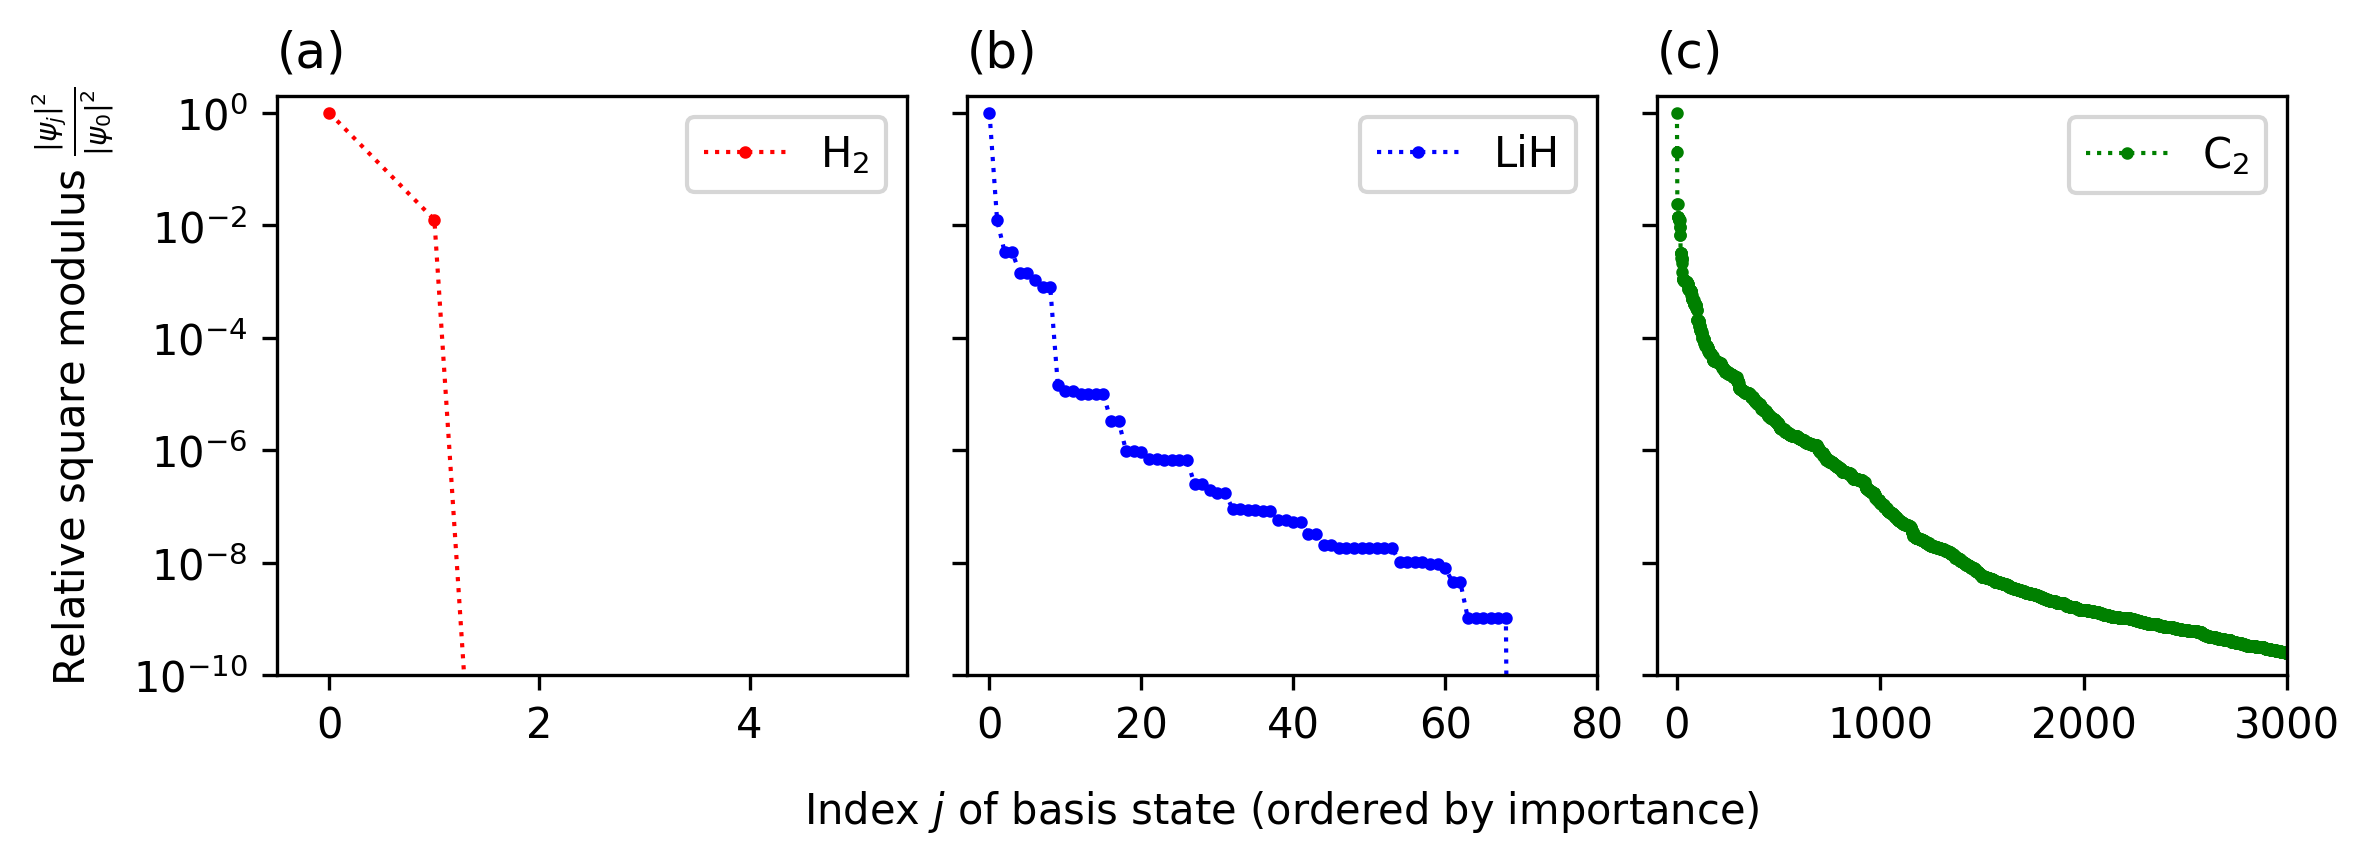

In [110]:
fig, sub = plt.subplots(1, 3, figsize=(8, 3), sharey=True, squeeze=True, dpi=300)
ax1 = sub[0]
ax2 = sub[1]
ax3 = sub[2]

ax1.plot(xs[2], amps[2], linestyle = ':', lw=1, marker='o', markersize=2, color='red', label=r'H$_2$')
ax2.plot(xs[0], amps[0], linestyle = ':', lw=1, marker='o', markersize=2, color='blue', label=r'LiH')
ax3.plot(xs[1], amps[1], linestyle = ':', lw=1, marker='o', markersize=2, color='green', label=r'C$_2$')



ax2.set_xlabel(r'Index $j$ of basis state (ordered by importance)', labelpad=10)
ax1.set_ylabel(r'Relative square modulus $\frac{\left|\psi_j\right|^2}{\left|\psi_0\right|^2}$')
for ax in sub:
    ax.set_yscale('log')
    ax.set_ylim(1e-10, 2)
    ax.legend()
#ax.set_xscale('log')
ax1.set_xlim(-0.5,5.5)
ax2.set_xlim(-3, 80)
ax3.set_xlim(-100,3000)

ax1.text(0, 1.05, '(a)', transform=ax1.transAxes, size=12)
ax2.text(0, 1.05, '(b)', transform=ax2.transAxes, size=12)
ax3.text(0, 1.05, '(c)', transform=ax3.transAxes, size=12)

#fig.subplots_adjust(left=0.15)
fig.tight_layout()
plt.savefig('../data/plots/ED_square_modulus.png')#, facecolor='w')
plt.show()

In [8]:
###### Load RBM #######
# path = './../data/RBM_runs/H2_for_plot/'
# filename = 'rbm_sto3g_H2_0-7348_eq1_a1_sgd_lr01_ns10000_trick'
# path = './../data/RBM_runs/C2_final_test/'
# filename = 'rbm_sto3g_C2_1-2600_eq1_a1_sgd_lr1_ns10000_trick'
path = './../data/RBM_runs/sweep2_LiH/'
filename = 'rbm_sto3g_LiH_1-5474_eq1_a2_adamax_lr1_ns100000_trick'

ha = JW_H(systemData=systemData)
g = nk.graph.Hypercube(n_dim=1, length=ha.hilbert.size, pbc=False)
hi = nk.hilbert.Qubit(graph=g)

# Define RBM
alpha = 2
ma = nk.machine.RbmSpin(hi, alpha=alpha)
ma.load(path+filename+'.wf')

chain_length = 1
sa = nk.sampler.MetropolisExchange(machine=ma, n_chains=chain_length)

n_up = []
tries = 20000
for i in range(tries):
    n_up = []
    sa = nk.sampler.MetropolisExchange(machine=ma, n_chains=chain_length)
    for ss in sa.samples(1):
        for s in ss:
             #print(s, list(s).count(1))
             n_up.append(int(list(s).count(1)))
    if n_up.count(systemData["n_electrons"]) == chain_length: print('found after %d tries' %(i)); break
if i+1==tries:
    print('not found')
else:
    for s in sa.samples(2):
        print(s)

found after 24 tries
[[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.]]


In [15]:
samples = sa.generate_samples(int(1e6))
COUNTER = Counter([str(s) for s in samples])

In [16]:
states = []
counts = []
for s, c in COUNTER.most_common(100):
    states.append(s)
    counts.append(c)

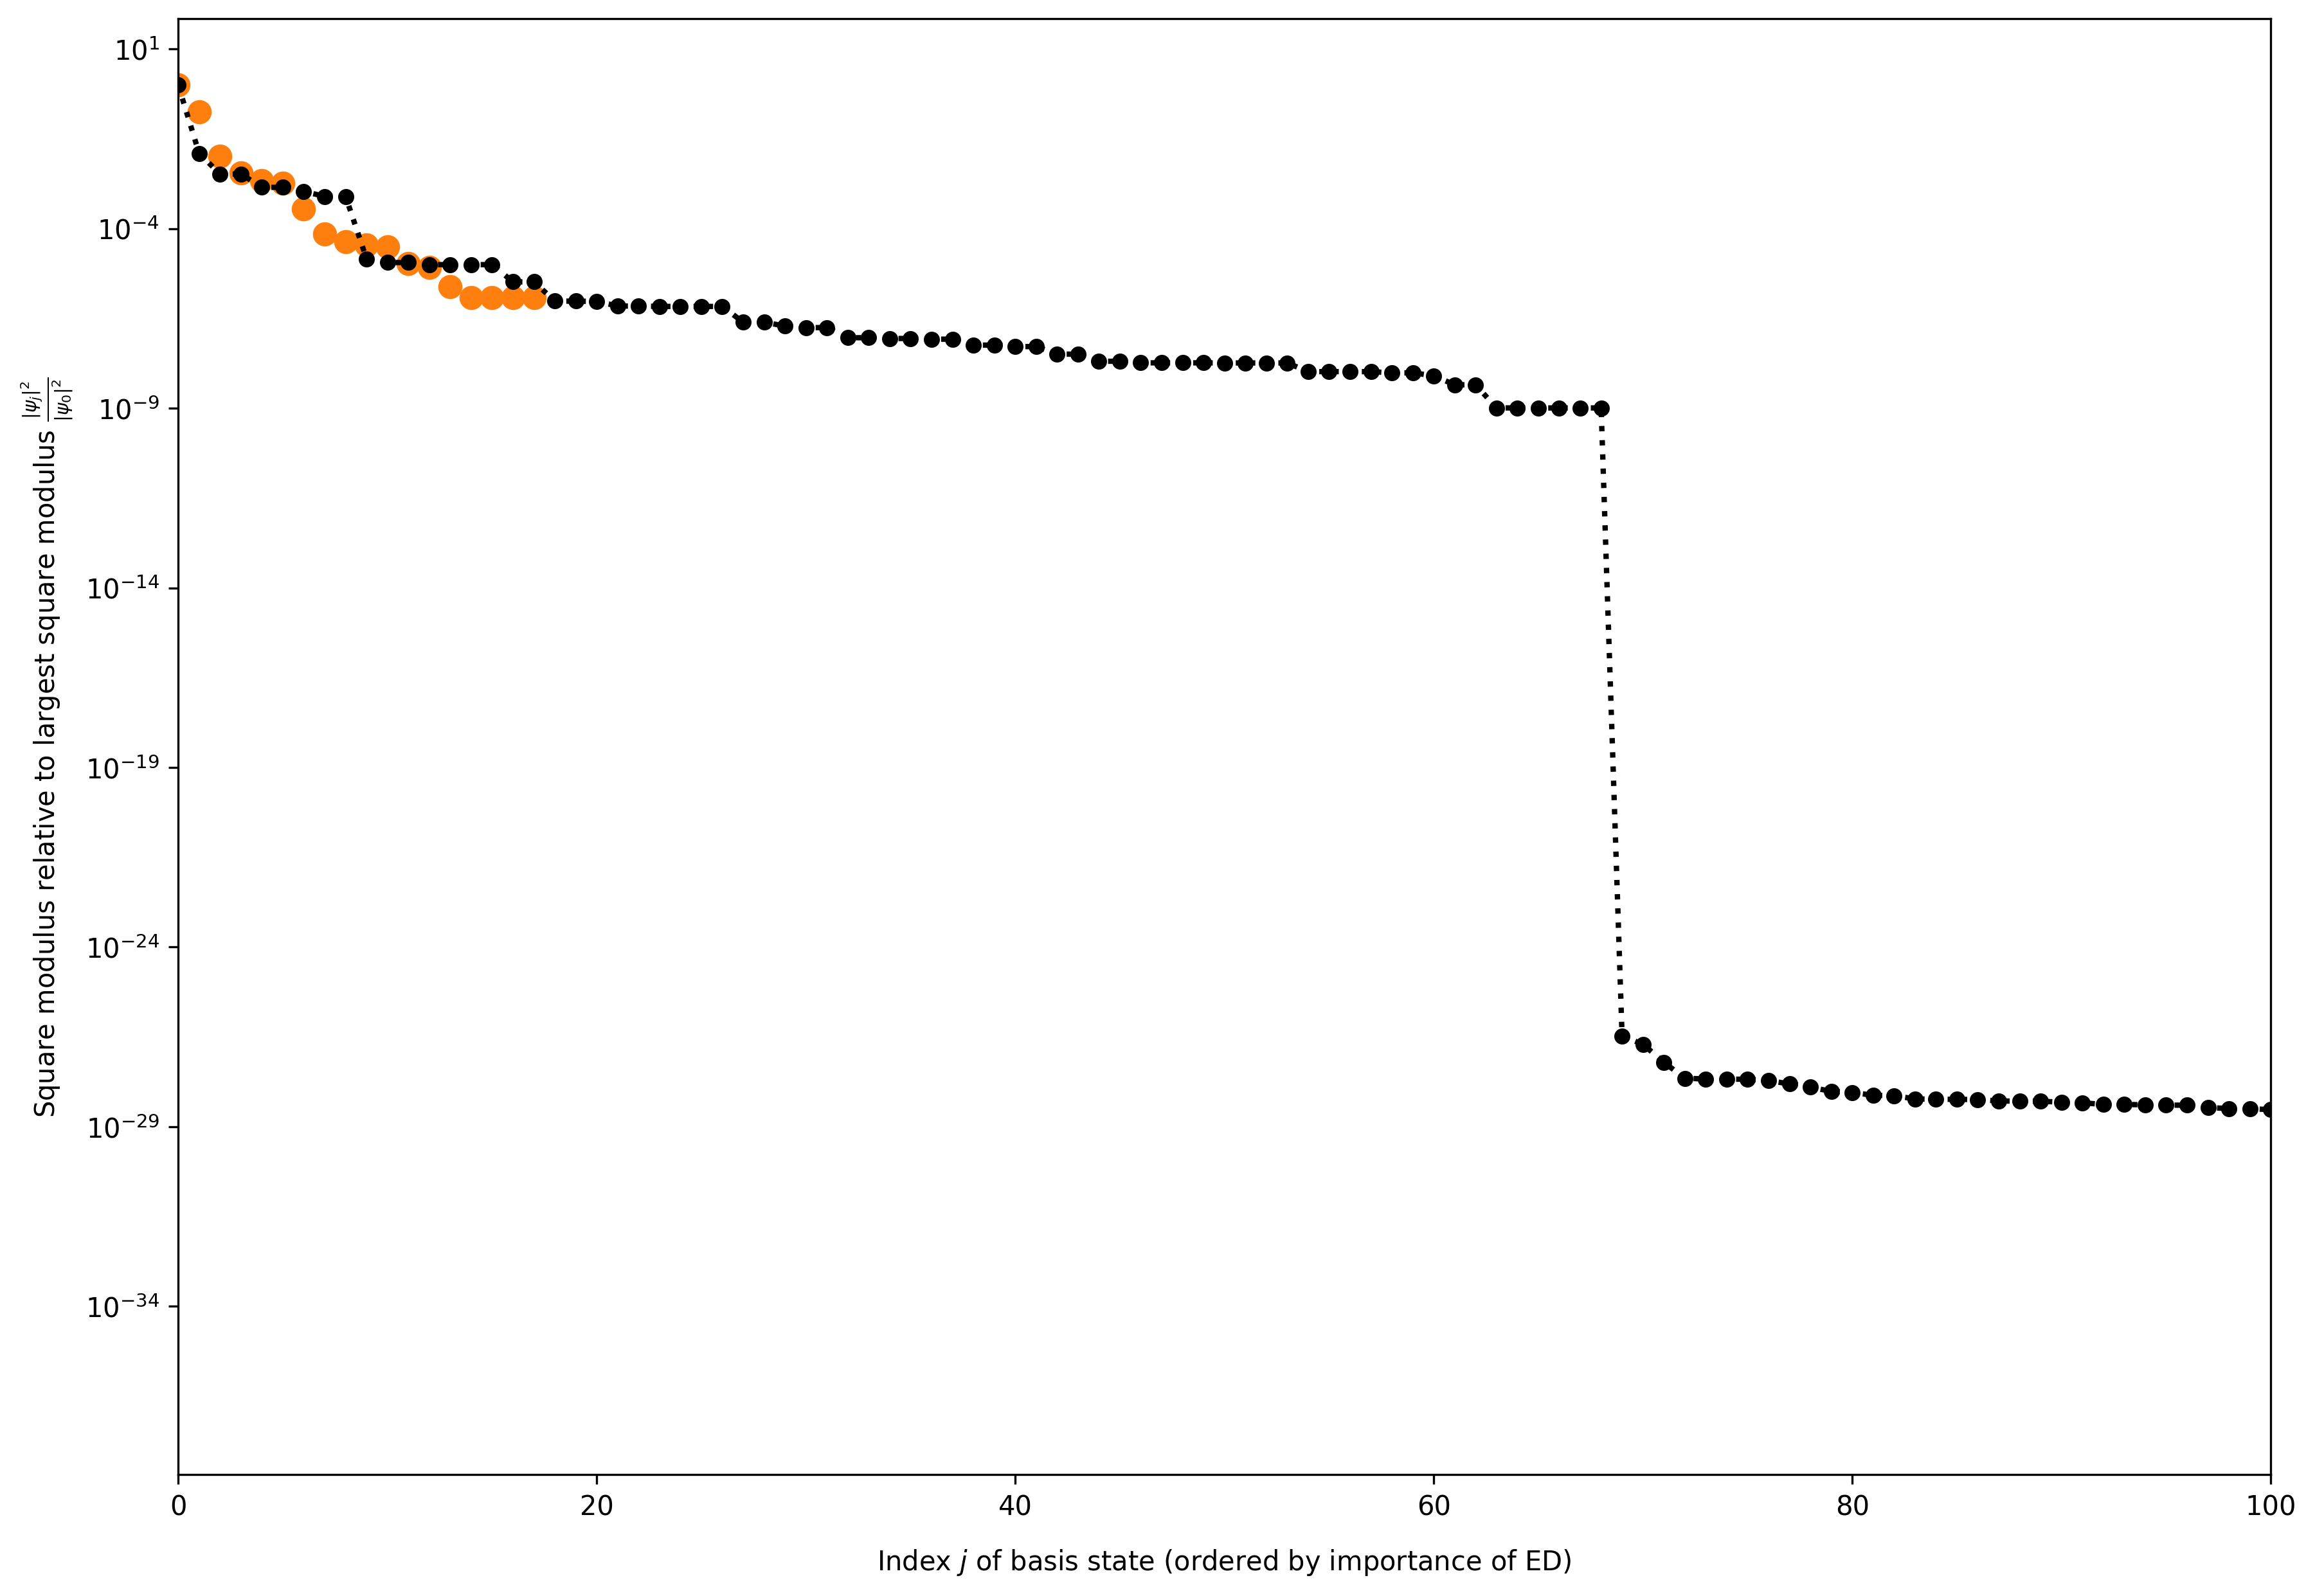

In [20]:
plt.fig, sub = plt.subplots(1, 1, figsize=(14, 10), squeeze=False, dpi=300)
ax = sub[0][0]
opaqueness=1
x = np.arange(len(states))
ax.scatter(x, np.array(counts)/max(counts), alpha=opaqueness, color='tab:orange', linewidths=3, label='RBM')
#ax.scatter(x, alpha=opaqueness, color='tab:blue', linewidths=3, label='RNN')
ax.plot(np.arange(hi.n_states), amplitudes_ED, linestyle = ':', lw=2, marker='o', markerfacecolor='k', markersize=5, color='k', label='Exact diagonalization')

ax.set_xlabel(r'Index $j$ of basis state (ordered by importance of ED)', labelpad=10)
ax.set_ylabel(r'Square modulus relative to largest square modulus $\frac{\left|\psi_j\right|^2}{\left|\psi_0\right|^2}$')
ax.set_yscale('log')
ax.set_xlim(0,100)
plt.show()

In [ ]:
states = [str(st) for st in hi.states()]
counts = np.zeros(len(states))

In [ ]:
for i in range(10):
    sss = sa.generate_samples(100000)
    ss = [str(sss[i][j]) for i,j in itertools.product(range(len(sss)),range(4))]
    counts += [ss.count(st) for st in states]

In [ ]:
for i in range(10):
    vmc.run(n_iter=1)
    sss = vmc._samples
    ss = [str(sss[i][j]) for i,j in itertools.product(range(len(sss)),range(4))]
    counts += [ss.count(st) for st in states]
    print(sum(counts))

In [ ]:
vmc.energy.mean + systemData['nuc_rep_energy']

In [ ]:
counts2, states2 = zip(*sorted(zip(counts, states)))

In [ ]:
fig, sub = plt.subplots(1, 1, figsize=(14, 10), squeeze=False, dpi=300)
ax = sub[0][0]
opaqueness=1
x = np.arange(hi.n_states)
ax.scatter(x, np.array(counts2[::-1])/max(counts2), alpha=opaqueness, color='tab:orange', linewidths=3, label='RBM')
#ax.scatter(x, alpha=opaqueness, color='tab:blue', linewidths=3, label='RNN')
ax.plot(x, amplitudes_ED, linestyle = ':', lw=2, marker='o', markerfacecolor='k', markersize=5, color='k', label='Exact diagonalization')

ax.set_xlabel(r'Index $j$ of basis state (ordered by importance of ED)', labelpad=10)
ax.set_ylabel(r'Square modulus relative to largest square modulus $\frac{\left|\psi_j\right|^2}{\left|\psi_0\right|^2}$')
ax.set_yscale('log')
#ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xlim(0,100)
plt.show()